Sort people into leagues for curling
KL 8/17/2016; update 8/30/2016; update 9/15/2016

This version randomizes the people first

In [1058]:
# Before running this:
#     (1) decide on max # of leagues and change that in the input.csv file,
#     (2) decide on nLimit for each league
#     (3) might need to optimize people's priority lists to increase number getting into 4 pm

In [1059]:
#the -f does this without user confirmations
%reset -f

In [1060]:
setSeed = False

In [1061]:
#set the random seed...if a number...will be able to recreate the random numbers
if setSeed == True:
    SEED = 42
elif setSeed == False:
    SEED = None

In [1062]:
import pandas as pd
import numpy as np
import math
import csv
import os
from datetime import datetime

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 

%matplotlib inline

Define some functions up top

In [1063]:
def addOne(leagueDict,oneLeague,oneName):
    if len(leagueDict[oneLeague])==0: #nothing there yet
        leagueDict[oneLeague] = oneName
    else:     #need to append
        leagueDict[oneLeague] = leagueDict[oneLeague].append(oneName)
    return leagueDict

In [1064]:
def addManager(leagueDictionary,r,manager): #here r is the index in...
    useRow = r.index[0]
    oneName = regSorted.loc[useRow,['lastname', 'firstname']] 
    oneName = oneName.to_frame().transpose() #need this format to make nice output
    leagueDictionary[manager] = oneName
    regSorted.loc[useRow,manager]=np.nan
    regTracking.loc[useRow,manager]='yes'
    return leagueDictionary

In [1065]:
def addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues):
    #person is interested in open leagues, oneLeague will be index in their next choice
    oneLeague = regSorted.loc[idx,openLeagues].dropna().idxmin()

    oneName = regSorted.loc[idx,['lastname', 'firstname']] 
    oneName = oneName.to_frame().transpose() #need this format to make nice output

    if len(leagueDict_open[oneLeague]) < (nLimit.loc[oneLeague,'nLimit']): #room in league
        leagueDict_open = addOne(leagueDict_open,oneLeague,oneName)
        #now that I have added the person to a league, change their priority to NaN
        regSorted.loc[idx,oneLeague] = np.nan
        regTracking.loc[idx,oneLeague] = 'yes'

    elif len(leagueDict_open[oneLeague]) == (nLimit.loc[oneLeague,'nLimit']):
        #league is full...does this person have another league listed?
        #first, set current to NaN
        regSorted.loc[idx,oneLeague] = np.nan
        regTracking.loc[idx,oneLeague] = 'no' #did not get in
        nextPriority = regSorted.loc[idx,openLeagues].dropna().min()
        if math.isnan(nextPriority)!=1: #have a number
            #go to the next league on their list
            nextLeague = regSorted.loc[idx,openLeagues].dropna().idxmin()
            #only add person is league has space
            if len(leagueDict_open[nextLeague]) < (nLimit.loc[nextLeague,'nLimit']):
                leagueDict_open = addOne(leagueDict_open,nextLeague,oneName)
                regSorted.loc[idx,nextLeague] = np.nan
                regTracking.loc[idx,nextLeague] = 'yes'
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==1):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInFirst',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==2):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInSecond',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==3):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInThird',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==4):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInFourth',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==5):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInFifth',oneName)
        elif math.isnan(nextPriority)==1:
            trackIssues=addOne(trackIssues,'noAdditionalChoice',oneName)
                           
    return regSorted, regTracking, leagueDict_open, trackIssues

Read in the data

In [1066]:
#updated 8/30/2016 to use file from website
#fName = 'BackupList_Registrations.csv' 
fName = 'registrations_KL_forPython.csv'
importInfo=pd.read_csv(fName)

In [1067]:
#shuffle the information from the website site to match the format in the rest of this file
openLeagues = ['Sunday Night', 'Monday 4PM', 'Monday Night',
               'Tuesday 4PM','Wednesday 4PM','Thursday 4PM'] #updated to match the priority list
otherLeagues = ['League_4_Men', 'League_7_Ladies' ,'League_Scrod']
priorities = ['League_Pri_1','League_Pri_2','League_Pri_3','League_Pri_4','League_Pri_5','League_Pri_6']

regInfo = importInfo.loc[:,(['firstname','lastname','email','League_Number_Open'] + otherLeagues)]

for item in openLeagues:
    regInfo[item] = np.nan

nPeople = len(regInfo.index)
for idx in range(0,nPeople):
    for idxP in enumerate(priorities):
        #remember: enumerate will allow idxP[0] is the number, while idxP[1] is the value
        getOne = importInfo.loc[idx,idxP[1]]
        if getOne != 'None':
            regInfo.loc[idx,getOne] = idxP[0] + 1  #want 1,2,3 and not python zero index

In [1068]:
# regTracking.loc[regTracking['lastname']=='Longnecker']

In [1069]:
#first, how many random numbers so I need?
nPeople = len(regInfo.index)
np.random.seed(SEED)
regInfo['randomNumCol'] = np.random.choice(range(nPeople), nPeople,replace = False)
##so now, moving back to the list of people, sort the list by the random number
regSorted = regInfo.sort_values(by = 'randomNumCol', ascending=True)
regSorted = regSorted.set_index(['randomNumCol'])

#copy so I can have an output tracking what was done, make after I put in league managers
regTracking = regSorted.copy(deep=True)

In [1070]:
issueNames = ['notInFirst','notInSecond','notInThird','notInFourth','notInFifth','noAdditionalChoice']
#setup the dictionary to hold the issues
trackIssues = {}
for name in issueNames:
    trackIssues[name] = pd.DataFrame()

In [1071]:
#setup the dictionary to hold the people information (start with openLeagues only)
forDictionary = openLeagues
#forDictionary.extend(otherLeagues)
leagueDict_open = {}
for name in forDictionary:
    leagueDict_open[name] = pd.DataFrame()

In [1072]:
#set the limit for each league (can set to big numbers to see how oversubscribed each league is)
sevenTeams = 28 #change to 28 (remember league manager already in here)
eightTeams = 32
fourteenTeams = 56

d = {'Sunday Night': eightTeams,
     'Monday 4PM': eightTeams,
     'Monday Night': fourteenTeams,
     'Tuesday 4PM': sevenTeams,
     'Wednesday 4PM': sevenTeams,
     'Thursday 4PM': sevenTeams,}

nLimit = pd.DataFrame({'nLimit' : d})
del d

In [1073]:
# put the manager information into a loop bc need to check later for them, updated 12/17/2016
names = [['Bill','Fragaszy'],['Richard','Lousararian'],['George', 'Bagley'],['Kenny', 'Thomson'],
        ['Katie', 'Murphy'],['Bill', 'Gallagher']]
leagues = ['Sunday Night','Monday 4PM','Monday Night','Tuesday 4PM','Wednesday 4PM','Thursday 4PM']

managers = pd.DataFrame(names,columns = ['firstname','lastname'],index = [leagues])
del names,leagues

if True:
    #can skip this because everyone will get their first choice. However, pending conversations 
    #with the curling committee, this may change
    #put the league managers into their league and set their the choice for that league to NaN
    for oL,item in managers.iterrows():
        r = regSorted.loc[(regSorted['lastname']==item.lastname) & (regSorted['firstname']==item.firstname)]
        leagueDict_open = addManager(leagueDict_open,r,oL)

In [1074]:
#go forwards through the list to start, skip over league managers bc already have 1st choice:
iteration = 1
for idx in (range(0,nPeople)):
    #ignore person who does not want open leagues 
    if (regTracking.loc[idx,'League_Number_Open'] != 'None'):
        t = regTracking.loc[idx,['firstname','lastname']]
        if len(managers.loc[(managers['lastname']==t.lastname) & (managers['firstname']==t.firstname)]) != 1:            
            #only do something if a person is still looking for more leagues...
            rt = regTracking.loc[idx,openLeagues]
            cHave = len(rt[rt=='yes'])
            del rt
            #NOTE: League_Number_Open will return a string...change to int
            if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
                onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
                if math.isnan(float(onePriority))==False:
                    regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)

In [1075]:
#now go backwards through the list to fill the other spots
iteration = 2
for idx in (range(0,nPeople)):
    #ignore person who does not want open leagues:
    if regTracking.loc[idx,'League_Number_Open'] != 'None':
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)        

In [1076]:
#go forwards again
iteraction = 3
for idx in (range(0,nPeople)):
    #ignore person who does not want open leagues:
    if regTracking.loc[idx,'League_Number_Open'] != 'None':
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)

In [1077]:
#only one person wants to curl 4x and I know there will not be space...stop here

In [1078]:
#make a new dictionary for other leagues...concat with openLeagues when done
# do doubles and competitive league by hand...
otherLeagues = ['League_4_Men', 'League_7_Ladies' ,'League_Scrod']

leagueDict_other = {}
for name in otherLeagues:
    leagueDict_other[name] = pd.DataFrame()

In [1079]:
#only have to go through once
for idx in range(0,nPeople):
    for oL in otherLeagues:
    
        oneName = regSorted.loc[idx,['lastname', 'firstname']] 
        oneName = oneName.to_frame().transpose() #need this format to make nice output
        if regSorted.loc[idx,oL]=='Yes': #careful with trailing spaces
            leagueDict_other = addOne(leagueDict_other,oL,oneName)
            #now that I have added the person to a league, change their priority to NaN
            regTracking.loc[idx,oL] = 'done'
            regSorted.loc[idx,oL] = np.nan

In [1080]:
#combine the two dictionaries
leagueDict_all = leagueDict_open.copy()
leagueDict_all.update(leagueDict_other)

#combine the list of names
allLeagues = list(openLeagues)
allLeagues.extend(otherLeagues)

In [1081]:
#finally, export the results 
folder = 'result_' + datetime.now().strftime("%Y%m%d-%H%M%S")
if not os.path.exists(folder):
    os.makedirs(folder)
else:
    raise ValueError('Something wrong, this folder already exists')

#change this to sort alphabetically before exporting
for fn in allLeagues:
    fName = '%s.csv' % fn
    #new folder for each run...
    tData = leagueDict_all[fn].sort_values(by = 'lastname')
    tData.to_csv(folder + '/' + fName)

can ran multiple times and saved the output

In [1082]:
#count up number of issues
for problem in issueNames:
    print(problem, ': ', len(trackIssues[problem]), ' people in this category')

notInFirst :  0  people in this category
notInSecond :  1  people in this category
notInThird :  0  people in this category
notInFourth :  0  people in this category
notInFifth :  0  people in this category
noAdditionalChoice :  0  people in this category


,nPeople
Sunday Night,32.0
Monday 4PM,32.0
Monday Night,42.0
Tuesday 4PM,28.0
Wednesday 4PM,26.0
Thursday 4PM,28.0


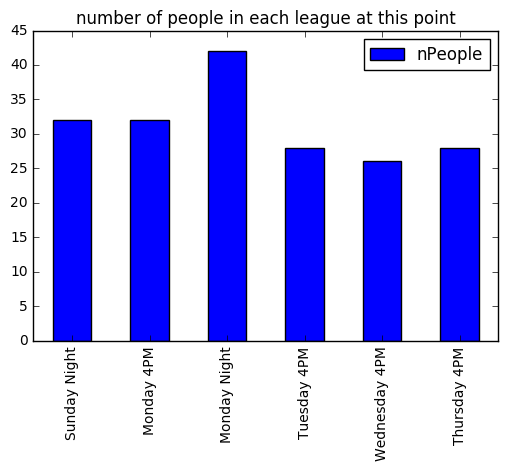

In [1083]:
#do some plotting...visually see how people distributed
gather = pd.DataFrame(np.nan, index = openLeagues, columns=['nPeople'])
for name in openLeagues:
    gather.loc[name,'nPeople'] = len(leagueDict_open[name])
    
gather.plot(kind = 'bar',title='number of people in each league at this point')
gather

In [1084]:
#gather up the number of people with # 'yes' < League_Number_Open
outcome = regTracking.copy(deep = True)

for idx in range(0,len(regTracking)):   
    if regTracking.loc[idx,'League_Number_Open'] != 'None':
        r = regTracking.loc[idx,openLeagues]
        nLeagues = 0
        for item in range(0,len(r)):
            if r[item] == 'yes':
                nLeagues = nLeagues + 1
        if nLeagues == int(regTracking.loc[idx,'League_Number_Open']):
            #delete from the dataframe
            outcome.drop(idx,inplace = True)
    else: #did not want open leagues, drop them too
        outcome.drop(idx,inplace = True)
        
outcome.sort_values(by = 'League_Number_Open', inplace = True)

In [1085]:
len(outcome)

1

In [1086]:
outcome

,firstname,lastname,email,League_Number_Open,League_4_Men,League_7_Ladies,League_Scrod,Sunday Night,Monday 4PM,Monday Night,Tuesday 4PM,Wednesday 4PM,Thursday 4PM,nan
randomNumCol,,,,,,,,,,,,,,
177,Martha,Balas,mfbalas@verizon.net,3,No,No,No,NaN,yes,NaN,no,yes,no,NaN


In [1087]:
outcome.to_csv(folder + '/exportOutcome.csv')
regTracking.to_csv(folder + '/exportTracking.csv')
regSorted.to_csv(folder + '/exportSorted.csv')
regInfo.to_csv(folder + '/exportInfo.csv')

In [1088]:
#can run multiple times and see what the best possible outcome is...would want to keep that...

In [1090]:
for problem in issueNames:
    print(problem, ': ', len(trackIssues[problem]), ' people in this category')

notInFirst :  0  people in this category
notInSecond :  1  people in this category
notInThird :  0  people in this category
notInFourth :  0  people in this category
notInFifth :  0  people in this category
noAdditionalChoice :  0  people in this category


In [1096]:
regTracking.loc[regTracking['lastname']=='Kavanagh']

,firstname,lastname,email,League_Number_Open,League_4_Men,League_7_Ladies,League_Scrod,Sunday Night,Monday 4PM,Monday Night,Tuesday 4PM,Wednesday 4PM,Thursday 4PM,nan
randomNumCol,,,,,,,,,,,,,,
189,Pat,Kavanagh,PKavanagh5@aol.com,2,No,No,No,yes,4,NaN,5,yes,3,NaN
197,Mary,Kavanagh,M84PAT@aol.com,2,No,No,No,yes,4,NaN,5,yes,3,NaN
